### 加載資料

In [78]:
import pandas as pd
import numpy as np
from smartmoneyconcepts import smc
from collections import defaultdict
import matplotlib.pyplot as plt
import math

def prepare_data(type_of_data, data_name):
    result = type_of_data.split('/')[0]
    tmp = pd.read_csv(f'./index_data/{type_of_data}/{data_name}.csv')
    if result == 'shioaji':
        tmp['ts'] = pd.to_datetime(tmp['ts'])
        tmp = tmp.rename(columns=lambda x: x.lower())
    else:
        tmp['ts'] = pd.to_datetime(tmp['datetime'])
        tmp = tmp.rename(columns=lambda x: x.lower())
    
    return tmp

# df1 = prepare_data('shioaji/2025_0304', 'TMFR1')
df1 = prepare_data('shioaji/2025_0404', 'TMFR1')

# 自定義函數處理 tick_type 分析
def analyze_tick_types(tick_types):
    """
    分析該秒內的成交類型分布
    :param tick_types: Series, 該秒內的 tick_type 列表
    :return: dict, 包括內盤、外盤成交數量及主要成交方向
    """
    tick_types = tick_types.tolist()  # 轉換為列表
    outer_trades = tick_types.count(1)  # 外盤成交數量
    inner_trades = tick_types.count(-1)  # 內盤成交數量
    net_trades = outer_trades - inner_trades  # 淨成交量
    dominant = "外盤" if net_trades > 0 else "內盤" if net_trades < 0 else "均衡"
    return {
        "outer_trades": outer_trades,
        "inner_trades": inner_trades,
        "dominant": dominant
    }

# 資料時間調整 # day日盤, night夜盤
def pre_process(df1, data_type, date_start, date_end):
    # 假设你的df已经加载到dataframe
    df1['ts'] = pd.to_datetime(df1['ts'])  # 将ts列转换为datetime类型

    # 按秒分组
    df1 = df1.groupby(df1['ts'].dt.floor('s')).agg({
        'close': 'last', 
        'volume': 'sum', 
        'bid_price': lambda x: tuple(sorted([i for i in x if i > 0])),  # 排除 0 和 NaN
        'bid_volume': 'sum', 
        'ask_price': lambda x: tuple(sorted([i for i in x if i > 0])),  # 排除 0 和 NaN
        'ask_volume': 'sum', 
        'tick_type': lambda x: analyze_tick_types(x)
    }).reset_index()
    
    # 展開內盤、外盤和主要成交方向
    df1['outer_trades'] = df1['tick_type'].apply(lambda x: x['outer_trades'])
    df1['inner_trades'] = df1['tick_type'].apply(lambda x: x['inner_trades'])
    df1['dominant'] = df1['tick_type'].apply(lambda x: x['dominant'])
    
    # 刪除原始的 tick_type 列
    df1.drop(columns=['tick_type'], inplace=True)

    # 创建时间范围从開始到結束天數（或多个天数），每天包含9:00:00到13:30:00之间的每一秒
    time_range = pd.date_range(date_start, date_end, freq='s')

    # 将时间范围转换为DataFrame
    full_time_df = pd.DataFrame(time_range, columns=['ts'])
    
    if data_type == 'day':
        # 通过检查时间是否在9:00:00到13:30:00之间来剔除跨天的数据
        valid_time_range = full_time_df['ts'].dt.time.between(pd.to_datetime('09:00:00').time(), pd.to_datetime('13:30:00').time())
        valid_time = full_time_df[valid_time_range]
        
    elif data_type == 'night':
        # 定义有效时间范围
        def is_valid_time(time):
            # 日盘时间：09:00:00 到 13:30:00
            if time.time() >= pd.to_datetime('08:45:00').time() and time.time() <= pd.to_datetime('13:45:00').time():
                return True
            # 夜盘时间：15:00:00 到 隔天 04:00:00
            elif time.time() >= pd.to_datetime('15:00:00').time() or time.time() <= pd.to_datetime('05:00:00').time():
                return True
            else:
                return False

        # 筛选出有效时间
        valid_time = full_time_df[full_time_df['ts'].apply(is_valid_time)]

    # 合并df1和df2的结果，确保它们与mer_ori_data按秒对齐, 首先将df1和df2与mer_ori_data合并，使用'left'连接方式，以保留所有有效时间
    merged_df1 = pd.merge(valid_time, df1, on='ts', how='left')

    # 设置'ts'为index
    merged_df1.set_index('ts', inplace=True)

    # 删除含有NaN的行
    mer_ori_data = merged_df1.dropna()
    mer_ori_data.ffill()
    
    return mer_ori_data

# mer_ori_data = pre_process(df1, 'night', '2025-02-27 15:00:00', '2025-04-25 13:45:00')
mer_ori_data = pre_process(df1, 'night', '2025-04-18 15:00:00', '2025-04-28 13:45:00')

print(mer_ori_data.head(5))

                       close  volume  \
ts                                     
2025-04-18 15:00:00  19345.0    58.0   
2025-04-18 15:00:01  19349.0     8.0   
2025-04-18 15:00:02  19350.0    11.0   
2025-04-18 15:00:03  19345.0    23.0   
2025-04-18 15:00:04  19343.0     4.0   

                                                             bid_price  \
ts                                                                       
2025-04-18 15:00:00  (19345.0, 19345.0, 19345.0, 19345.0, 19345.0, ...   
2025-04-18 15:00:01      (19343.0, 19343.0, 19343.0, 19343.0, 19343.0)   
2025-04-18 15:00:02                        (19348.0, 19348.0, 19348.0)   
2025-04-18 15:00:03  (19345.0, 19345.0, 19345.0, 19348.0, 19348.0, ...   
2025-04-18 15:00:04               (19343.0, 19343.0, 19343.0, 19343.0)   

                     bid_volume  \
ts                                
2025-04-18 15:00:00        25.0   
2025-04-18 15:00:01        38.0   
2025-04-18 15:00:02         3.0   
2025-04-18 15:00:03      

In [79]:
# 定義一個函數，將秒級資料轉換為指定時間級別的 OHLCV
def resample_to_ohlcv(df, timeframe='1min'):
    # 使用 resample 進行時間級別聚合
    ohlcv = df.resample(timeframe).agg({
        'close': ['first', 'max', 'min', 'last'],  # open, high, low, close
        'volume': 'sum' # 成交量總和
    })
    
    # 展平多層次欄位名稱
    ohlcv.columns = ['open', 'high', 'low', 'close', 'volume']
    
    # 移除可能的 NaN 值（例如空時間區間）
    ohlcv = ohlcv.dropna()
    
    return ohlcv

data1 = resample_to_ohlcv(mer_ori_data, '240min')
data2 = resample_to_ohlcv(mer_ori_data, '15min')
data3 = resample_to_ohlcv(mer_ori_data, '5min')
print(data1.head(5))
print(data2.head(5))
print(data3.head(5))

                        open     high      low    close  volume
ts                                                             
2025-04-18 12:00:00  19345.0  19360.0  19312.0  19339.0  3289.0
2025-04-18 16:00:00  19338.0  19350.0  19322.0  19332.0  3654.0
2025-04-18 20:00:00  19331.0  19349.0  19330.0  19339.0  2435.0
2025-04-19 00:00:00  19339.0  19399.0  19336.0  19380.0  3645.0
2025-04-19 04:00:00  19380.0  19381.0  19366.0  19372.0   647.0
                        open     high      low    close  volume
ts                                                             
2025-04-18 15:00:00  19345.0  19360.0  19338.0  19351.0  1544.0
2025-04-18 15:15:00  19350.0  19355.0  19312.0  19325.0  1030.0
2025-04-18 15:30:00  19327.0  19338.0  19321.0  19337.0   431.0
2025-04-18 15:45:00  19337.0  19342.0  19331.0  19339.0   284.0
2025-04-18 16:00:00  19338.0  19345.0  19333.0  19338.0   370.0
                        open     high      low    close  volume
ts                                      

### SMC策略

In [216]:
def analyze(trade_result, is_plot=False):
    """
    分析交易結果，計算各項績效指標，基於收益率而非金額。
    
    參數:
    - trade_result: 交易記錄列表，每筆交易包含 'net_profit_loss', 'capital', 'timestamp', 'type'
    - is_plot: 是否繪製圖表
    
    返回:
    - 字典，包含績效指標
    """
    if not trade_result:
        return {
            'net_profit_loss': 0,
            'capital': 0,
            'win_count': 0,
            'loss_count': 0,
            'win_rate': 0,
            'max_drawdown': 0,
            'annualized_return': 0,
            'sharpe_ratio': 0,
            'sterling_ratio': 0,
            'omega_ratio': 0,
            'sortino_ratio': 0,
            'skewness': 0,
            'kurtosis': 0,
            'overall_conclusion': 'No trades to analyze.',
            'total_trades': 0,
            'type_performance': {}
        }

    # 計算總盈虧（金額）和勝負次數
    total_profit_loss = sum(trade['net_profit_loss'] for trade in trade_result)
    win_count = sum(1 for trade in trade_result if trade['net_profit_loss'] > 0)
    loss_count = sum(1 for trade in trade_result if trade['net_profit_loss'] < 0)
    win_rate = win_count / len(trade_result) if trade_result else 0
    total_trades = len(trade_result)
    capital = trade_result[-1]['capital']

    # 計算資本曲線與最大回撤（金額）
    equity_curve = [trade['capital'] for trade in trade_result]
    peak = equity_curve[0]
    max_drawdown = 0
    drawdown_curve = []
    for value in equity_curve:
        peak = max(peak, value)
        drawdown = peak - value
        drawdown_curve.append(drawdown)
        max_drawdown = max(max_drawdown, drawdown)

    # 計算收益率
    returns = [trade['net_profit_loss'] / trade['capital'] for trade in trade_result]
    n = len(returns)

    # 年化回報（基於收益率）
    total_return = sum(returns)
    annualized_return = (total_return / n * 252) if n > 0 else 0

    # 夏普比率
    avg_return = total_return / n if n > 0 else 0
    return_std = (sum((x - avg_return) ** 2 for x in returns) / n) ** 0.5 if n > 0 else 0
    annualized_std = return_std * math.sqrt(252)
    risk_free_rate = 0
    sharpe_ratio = ((annualized_return - risk_free_rate) / (annualized_std + 1e-9)) if annualized_std > 0 else 0

    # Sortino Ratio
    downside_returns = [min(0, x - risk_free_rate) for x in returns]
    downside_std = (sum(d**2 for d in downside_returns) / n) ** 0.5 if n > 0 else 0
    annualized_downside_std = downside_std * math.sqrt(252)
    sortino_ratio = ((annualized_return - risk_free_rate) / (annualized_downside_std + 1e-9)) if annualized_downside_std > 0 else 0

    # Sterling Ratio（使用相對回撤）
    relative_drawdown = max_drawdown / peak if peak > 0 else 0
    sterling_ratio = (annualized_return / (relative_drawdown + 1e-9)) if relative_drawdown > 0 else 0

    # Omega Ratio
    tau = 0
    excess_gains = [max(x - tau, 0) for x in returns]
    excess_losses = [max(tau - x, 0) for x in returns]
    omega_ratio = (sum(excess_gains) / (sum(excess_losses) + 1e-9)) if n > 0 else 0

    # 偏態與峭度
    if n > 0 and return_std > 0:
        skewness = sum((x - avg_return)**3 for x in returns) / (n * (return_std**3))
        kurtosis = sum((x - avg_return)**4 for x in returns) / (n * (return_std**4)) - 3
    else:
        skewness = 0
        kurtosis = 0

    # 肥尾與偏態結論
    fat_tail_conclusion = "收益分布具有肥尾特徵，極端值較常見。" if kurtosis > 0 else "收益分布尾部較薄，極端值較少。"
    skewness_conclusion = (
        "收益分布呈正偏態，偶有較大正收益。" if skewness > 0 else
        "收益分布呈負偏態，偶有較大負收益。" if skewness < 0 else
        "收益分布基本對稱。"
    )
    overall_conclusion = f"{fat_tail_conclusion} {skewness_conclusion}"

    # 按 type 計算績效（保留金額形式）
    type_performance = defaultdict(lambda: {
        'total_trades': 0,
        'win_count': 0,
        'loss_count': 0,
        'win_rate': 0,
        'total_profit_loss': 0,
        'profit_timestamps': [],
        'loss_timestamps': []
    })
    
    for trade in trade_result:
        trade_type = trade['type']
        timestamp = trade['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
        
        type_performance[trade_type]['total_trades'] += 1
        type_performance[trade_type]['total_profit_loss'] += trade['net_profit_loss']
        
        if trade['net_profit_loss'] > 0:
            type_performance[trade_type]['win_count'] += 1
            type_performance[trade_type]['profit_timestamps'].append(timestamp)
        elif trade['net_profit_loss'] < 0:
            type_performance[trade_type]['loss_count'] += 1
            type_performance[trade_type]['loss_timestamps'].append(timestamp)

    for trade_type, performance in type_performance.items():
        performance['win_rate'] = (
            performance['win_count'] / performance['total_trades']
            if performance['total_trades'] > 0 else 0
        )

    # 繪圖
    if is_plot:
        fig, axs = plt.subplots(3, 1, figsize=(12, 6))
        axs[0].plot(equity_curve, label="Equity (Capital) Curve", color="green")
        axs[0].set_title("Equity Curve")
        axs[0].set_ylabel("Capital")
        axs[0].legend()

        axs[1].plot(drawdown_curve, label="Max Drawdown", color="red")
        axs[1].set_title("Max Drawdown")
        axs[1].set_ylabel("Drawdown")
        axs[1].legend()

        cumulative_returns = [sum(returns[:i+1]) for i in range(len(returns))]
        axs[2].plot(cumulative_returns, label="Cumulative Return", color="blue")
        axs[2].set_title("Cumulative Return")
        axs[2].set_ylabel("Cumulative Return")
        axs[2].legend()

        plt.tight_layout()
        plt.show()

    return {
        'net_profit_loss': total_profit_loss,
        'capital': capital,
        'win_count': win_count,
        'loss_count': loss_count,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'annualized_return': annualized_return,
        'sharpe_ratio': sharpe_ratio,
        'sterling_ratio': sterling_ratio,
        'omega_ratio': omega_ratio,
        'sortino_ratio': sortino_ratio,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'overall_conclusion': overall_conclusion,
        'total_trades': total_trades,
        'type_performance': dict(type_performance)
    }

def calculate_vwap(df, window, include_std_bands=False):
    """
    計算滾動窗口的 VWAP，並可選擇為 5 分鐘 K 線計算標準差帶。
    
    參數:
    - df: Pandas DataFrame，包含 'open', 'high', 'low', 'close', 'volume' 列
    - window: 滾動窗口大小（K 線數量）
    - include_std_bands: 是否計算標準差帶（僅用於 5 分鐘 K 線）
    
    返回:
    - DataFrame，包含原始數據和新計算的列：
      - 'vwap': 滾動 VWAP 值
      - 若 include_std_bands=True，額外包含：
        - 'vwap_upper_1std', 'vwap_lower_1std': ±1 標準差帶
        - 'vwap_upper_2std', 'vwap_lower_2std': ±2 標準差帶
    """
    # 複製輸入 DataFrame，避免修改原始數據
    df = df.copy()
    
    # 計算典型價格 (High + Low + Close) / 3
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    
    # 計算價格 × 成交量
    df['price_volume'] = df['typical_price'] * df['volume']
    
    # 計算滾動窗口的 VWAP
    df['cum_price_volume'] = df['price_volume'].rolling(window=window, min_periods=1).sum()
    df['cum_volume'] = df['volume'].rolling(window=window, min_periods=1).sum()
    df['vwap'] = df['cum_price_volume'] / df['cum_volume']
    
    # 如果需要計算標準差帶（僅 5 分鐘 K 線）
    if include_std_bands:
        # 計算典型價格相對於 VWAP 的平方差
        df['price_diff_squared'] = (df['typical_price'] - df['vwap']) ** 2
        # 計算滾動標準差
        df['std'] = np.sqrt(df['price_diff_squared'].rolling(window=window, min_periods=1).mean())
        # 計算 ±1 和 ±2 標準差帶
        df['vwap_upper_2std'] = df['vwap'] + 2 * df['std']
        df['vwap_lower_2std'] = df['vwap'] - 2 * df['std']
        
        # 刪除中間計算列
        df = df.drop(columns=['price_diff_squared', 'std'])
    
    # 刪除中間計算列
    df = df.drop(columns=['typical_price', 'price_volume', 'cum_price_volume', 'cum_volume'])
    
    return df

def calculate_smc_indicators(df, swing_length, close_break=True):
    """
    計算 SMC 指標（FVG, OB, Liquidity, BOS, CHOCH）並返回統一的字典格式。
    
    參數:
    - df: Pandas DataFrame，包含 'open', 'high', 'low', 'close', 'volume' 列
    - swing_length: 波段高低點計算的窗口大小
    - close_break: BOS/CHOCH 是否基於收盤價突破
    
    返回:
    - 字典，包含以下 SMC 指標：
      - 'FVG': FVG 數據
      - 'OB': Order Block 數據
      - 'Liquidity': Liquidity 數據
      - 'BOS': BOS 數據（僅非空）
      - 'CHOCH': CHOCH 數據（僅非空）
      - 'Swing': 波段高低點數據
    """
    # 確保輸入 df 的索引是 DatetimeIndex
    df.index = pd.to_datetime(df.index)
    
    # 計算波段高低點
    swing_data = smc.swing_highs_lows(df, swing_length=swing_length)
    swing_data.index = df.index  # 對齊索引
    
    # 計算 FVG
    fvg_data = smc.fvg(df)
    fvg_data.index = df.index  # 對齊索引
    
    # 計算 Order Blocks
    ob_data = smc.ob(df, swing_data)
    ob_data.index = df.index  # 對齊索引
    
    # 計算 Liquidity
    liquidity_data = smc.liquidity(df, swing_data)
    liquidity_data.index = df.index  # 對齊索引
    
    # 計算 BOS 和 CHOCH
    bos_choch_data = smc.bos_choch(df, swing_data, close_break=close_break)
    bos_choch_data.index = df.index  # 對齊索引
    
    # 分離 BOS 和 CHOCH
    bos_data = bos_choch_data[bos_choch_data['BOS'].notna()][['BOS', 'Level', 'BrokenIndex']]
    choch_data = bos_choch_data[bos_choch_data['CHOCH'].notna()][['CHOCH', 'Level', 'BrokenIndex']]
    
    # 構建輸出字典
    smc_indicators = {
        'FVG': fvg_data,
        'OB': ob_data,
        'Liquidity': liquidity_data,
        'BOS': bos_data,
        'CHOCH': choch_data,
        'Swing': swing_data
    }
    
    return smc_indicators

def generate_signals(data1, data2, data3, smc_4h, vwap_4h, vwap_15m, vwap_5m, use_vwap_std=False):
    """
    生成交易信號，基於多時間框架的 SMC 指標和 VWAP，遵循指定策略。
    
    參數:
    - data1, data2, data3: 4 小時、15 分鐘、5 分鐘 K 線數據
    - smc_4h, smc_15m, smc_5m: 各時間框架的 SMC 指標字典
    - vwap_4h, vwap_15m, vwap_5m: 各時間框架的 VWAP 數據
    - use_vwap_std: 是否使用 5 分鐘 VWAP 標準差帶作為進場條件
    - ob_lookback: 4 小時 OB 和 FVG 的回溯 K 線數（預設 10）
    - require_fvg: 是否要求 OB 附近必須有 FVG（預設 True）
    
    返回:
    - DataFrame，包含 'timestamp' 和 'signal' 列（1: 買入，-1: 賣出，0: 無信號）
    """
    signals = []
    
    # 遍歷 5 分鐘 K 線
    for idx, row in data3.iterrows():
        timestamp = idx
        signal = 0

        # 步驟 1: 判斷趨勢
        try:
            # 找到當前 5 分鐘 K 線對應的最新 4 小時 K 和 15分鐘 K
            latest_4h_idx = data1.index[data1.index <= timestamp][-1]
            latest_15m_idx = data2.index[data2.index <= timestamp][-1]
           
            print(f"\n當前時刻: {timestamp}, 進行OB+FVG判斷")

            # 尋找 4 小時 OB
            ob_4h = smc_4h['OB'].loc[:latest_4h_idx].dropna()
            valid_ob = None
            for idx, ob in ob_4h.iloc[::-1].iterrows():  # 從最後一行向前遍歷
                if ob['OB'] == 1:  # 檢查當前行的OB值
                    print("當前為看漲OB")
                    valid_ob = ob
                elif ob['OB'] == -1:
                    print("當前為看跌OB")
                    valid_ob = ob
                if valid_ob is not None:
                    break

            if valid_ob is None:
                signals.append({'timestamp': timestamp, 'signal': 0})
                print(f"當前時刻: {timestamp}, 4小時區間沒有訂單塊")
                continue
            
            print(f"當前時刻: {timestamp},\n OB塊: {valid_ob}\n\n")
            
            # 尋找 4 小時 FVG
            fvg_4h = smc_4h['FVG'].loc[:latest_4h_idx].dropna()
            fvg_found = None
            for idx, fvg in fvg_4h.iloc[::-1].iterrows():  # 從最後一行向前遍歷
                if fvg['FVG'] == 1:  # 檢查當前行的FVG值
                    print("當前為看漲FVG")
                    fvg_found = fvg
                elif fvg['FVG'] == -1:
                    print("當前為看跌FVG")
                    fvg_found = fvg
                if fvg_found is not None:
                    break
            
            if fvg_found is None:
                print(f"當前時刻: {timestamp}, 4小時區間沒有FVG")
                signals.append({'timestamp': timestamp, 'signal': 0})
                continue
            
            print(f"當前時刻: {timestamp},\n FVG: {fvg_found}\n\n")

            if fvg_found.iloc[0] != valid_ob.iloc[0]:
                print(f"FVG: {fvg_found.iloc[0]} 和 OB: {valid_ob.iloc[0]} 判斷不相同, 一邊看漲(1), 一邊看跌(-1)")
                continue

            # 檢查 15 分鐘 K 是否回踩 4 小時 OB
            ob_top = valid_ob['Top']
            ob_bottom = valid_ob['Bottom']
            price_15m = data2.loc[latest_15m_idx, 'close']
            retraced_15m = ob_bottom <= price_15m <= ob_top

            if not retraced_15m:
                print(f"當前時刻: {timestamp}, 15分價格: {price_15m} 沒回踩OB: {valid_ob['Top']} ~ {valid_ob['Bottom']}")
                signals.append({'timestamp': timestamp, 'signal': 0})
                continue

            print(f"當前時刻: {timestamp}, 15分: {price_15m} 回踩OB: {valid_ob['Top']} ~ {valid_ob['Bottom']}")

            # 檢查 5 分鐘 K 是否回踩 4 小時 OB
            price_5m = row['close']
            retraced_5m = ob_bottom <= price_5m <= ob_top

            if not retraced_5m:
                print(f"當前時刻: {timestamp}, 5分價格: {price_5m} 沒回踩OB: {valid_ob['Top']} ~ {valid_ob['Bottom']}")
                signals.append({'timestamp': timestamp, 'signal': 0})
                continue

            print(f"當前時刻: {timestamp}, 5分: {price_15m} 回踩OB: {valid_ob['Top']} ~ {valid_ob['Bottom']}")

            # 步驟 3: VWAP 條件
            vwap_4h_value = vwap_4h.loc[latest_4h_idx, 'vwap']
            price_4h = data1.loc[latest_4h_idx, 'close']
            
            if valid_ob.iloc[0] == 1: # 買入信號要求價格高於VWAP
                if price_4h <= vwap_4h_value:  
                    print(f"當前時刻: {timestamp}, 做多但價格 {price_4h} 低於4小時VWAP {vwap_4h_value}, 不生成訊號")
                    signals.append({'timestamp': timestamp, 'signal': 0})
                    continue
                else:
                    print(f"當前時刻: {timestamp}, 做多且價格 {price_4h} 高於4小時VWAP {vwap_4h_value}")
            
            if valid_ob.iloc[0] == -1: # 賣出信號要求價格低於VWAP
                if price_4h >= vwap_4h_value:  
                    print(f"當前時刻: {timestamp}, 做空但價格 {price_4h} 高於4小時VWAP {vwap_4h_value}, 不生成訊號")
                    signals.append({'timestamp': timestamp, 'signal': 0})
                    continue
                else:
                    print(f"當前時刻: {timestamp}, 做空且價格 {price_4h} 低於4小時VWAP {vwap_4h_value}")

            vwap_15m_value = vwap_15m.loc[latest_15m_idx, 'vwap']
            if valid_ob.iloc[0] == 1:
                if price_15m <= vwap_15m_value:
                    print(f"當前時刻: {timestamp}, 做多但價格 {price_15m} 低於15分鐘VWAP {vwap_15m_value}, 不生成訊號")
                    signals.append({'timestamp': timestamp, 'signal': 0})
                    continue
                else:
                    print(f"當前時刻: {timestamp}, 做多且價格 {price_15m} 高於15分鐘VWAP {vwap_15m_value}")
            
            if valid_ob.iloc[0] == -1:
                if price_15m >= vwap_15m_value:
                    print(f"當前時刻: {timestamp}, 做空但價格 {price_15m} 高於於15分鐘VWAP {vwap_15m_value}, 不生成訊號")
                    signals.append({'timestamp': timestamp, 'signal': 0})
                    continue
                else:
                    print(f"當前時刻: {timestamp}, 做空且價格 {price_15m} 低於15分鐘VWAP {vwap_15m_value}")
                
            vwap_5m_value = vwap_5m.loc[timestamp, 'vwap']
            if valid_ob.iloc[0] == 1:
                if price_5m <= vwap_5m_value:
                    print(f"當前時刻: {timestamp}, 做多但價格 {price_5m} 低於5分鐘VWAP {vwap_5m_value}, 不生成訊號")
                    signals.append({'timestamp': timestamp, 'signal': 0})
                    continue
                else:
                    print(f"當前時刻: {timestamp}, 做多且價格 {price_5m} 高於5分鐘VWAP {vwap_5m_value}")
                
            if valid_ob.iloc[0] == -1:
                if price_5m >= vwap_5m_value:
                    print(f"當前時刻: {timestamp}, 做空但價格 {price_5m} 高於5分鐘VWAP {vwap_5m_value}, 不生成訊號")
                    signals.append({'timestamp': timestamp, 'signal': 0})
                    continue
                else:
                    print(f"當前時刻: {timestamp}, 做空且價格 {price_5m} 低於5分鐘VWAP {vwap_5m_value}")

            if use_vwap_std:
                vwap_upper_2std = vwap_5m.loc[timestamp, 'vwap_upper_2std']
                vwap_lower_2std = vwap_5m.loc[timestamp, 'vwap_lower_2std']
                if valid_ob.iloc[0] == 1:  # 買入信號（牛市OB）
                    if not (vwap_5m_value <= price_5m <= vwap_upper_2std):
                        signals.append({'timestamp': timestamp, 'signal': 0})
                        print(f"當前時刻: {timestamp}, 做多但5分價格: {price_5m} 不在VWAP之上, 且不在2倍標準差內: [{vwap_5m_value}, {vwap_upper_2std}]")
                        continue
                    else:
                        print(f"當前時刻: {timestamp}, 做多且5分價格: {price_5m} 在VWAP之上, 且在2倍標準差內: [{vwap_5m_value}, {vwap_upper_2std}]")
                elif valid_ob.iloc[0] == -1:  # 賣出信號（熊市OB）
                    if not (vwap_lower_2std <= price_5m <= vwap_5m_value):
                        signals.append({'timestamp': timestamp, 'signal': 0})
                        print(f"當前時刻: {timestamp}, 做空但5分價格: {price_5m} 不在VWAP之下, 且不在2倍標準差內: [{vwap_5m_value}, {vwap_lower_2std}]")
                        continue
                    else:
                        print(f"當前時刻: {timestamp}, 做空且5分價格: {price_5m} 在VWAP之下, 且在2倍標準差內: [{vwap_5m_value}, {vwap_lower_2std}]")

            # 所有條件滿足，生成訊號
            signal = 1 if valid_ob.iloc[0] == 1 else -1
            signals.append({'timestamp': timestamp, 'signal': signal})
            
        except (IndexError, KeyError) as e:
            signals.append({'timestamp': timestamp, 'signal': 0})
            continue
    
    # 創建並返回 DataFrame
    signals_df = pd.DataFrame(signals)
    if signals_df.empty:
        signals_df = pd.DataFrame(columns=['timestamp', 'signal'])
    else:
        signals_df.set_index('timestamp', inplace=True)
    return signals_df

def backtest(df, data1, data2, data3, **params):
    tick_size1 = params.get('tick_size1')
    min_margin1 = params.get('min_margin1')
    shares_per_trade1 = params.get('shares_per_trade1')
    tax1 = params.get('tax1')
    commission1 = params.get('commission1')
    profit_ratio1 = params.get('profit_ratio1')
    stop_ratio1 = params.get('stop_ratio1')
    capital = params.get('capital')
    entry_price_stock1, exit_price_stock1 = 0, 0
    position = 0
    profit_stop_stock1, stop_loss_stock1 = 0, 0
    trade_results = []
    
    # 計算 VWAP
    data1_vwap = calculate_vwap(data1, window=params.get('window_4h'), include_std_bands=False)
    data2_vwap = calculate_vwap(data2, window=params.get('window_15m'), include_std_bands=False)
    data3_vwap = calculate_vwap(data3, window=params.get('window_5m'), include_std_bands=True)
    
    # 計算 SMC 指標
    smc_4h = calculate_smc_indicators(data1, swing_length=params.get('swing_length_4h'), close_break=params.get('close_break'))
    
    # # 生成交易信號
    signals_df = generate_signals(data1, data2, data3, smc_4h, data1_vwap, data2_vwap, data3_vwap, use_vwap_std=True)
    
    print('生成交易訊號時間段: \n', signals_df[signals_df['signal'] != 0])
    return
    
    # 遍歷主時間框架（5 分鐘 K 線）
    for idx, row in df.iterrows():
        timestamp = idx
        current_price = row['close']
        
        if capital < min_margin1:
            print("金額已經低於保證金")
            break
        
        if position > 0: # 多倉
            pass
        elif position < 0: # 空倉
            pass

        # # 檢查是否有信號
        # if timestamp in signals_df.index:
        #     signal = signals_df.loc[timestamp]['signal']
            
            # # 買入信號
            # if signal == 1 and position == 0:
            #     position = 1
            #     entry_price = current_price
            #     entry_time = timestamp
            #     trade_results.append({
            #         'entry_price_stock1': entry_price_stock1,
            #         'exit_price_stock1': sell_price_stock1,
            #         'position_stock1': position_stock1,
            #         'profit_loss_stock1': profit_loss_stock1,
            #         'total_fees': sell_fee_stock1 + sell_tax_stock1,
            #         'net_profit_loss': profit_loss_stock1,
            #         'capital': capital,
            #         'timestamp': current_time,
            #         'type': 'long'
            #     })
            
            # # 賣出信號
            # elif signal == -1 and position == 0:
            #     position = -1
            #     entry_price = current_price
            #     entry_time = timestamp
            #     trade_results.append({
            #         'entry_price_stock1': entry_price_stock1,
            #         'exit_price_stock1': sell_price_stock1,
            #         'position_stock1': position_stock1,
            #         'profit_loss_stock1': profit_loss_stock1,
            #         'total_fees': sell_fee_stock1 + sell_tax_stock1,
            #         'net_profit_loss': profit_loss_stock1,
            #         'capital': capital,
            #         'timestamp': current_time,
            #         'type': 'short'
            #     })

In [217]:
params = {
    'k_time_long': 240,
    'k_time_middle': 15,
    'k_time_short': 5,
    'swing_length_4h': 5, # （建議範圍：5-8）
    'close_break': True,
    'ob_lookback': 10,
    'window_4h': 6,    # VWAP 約 1 天（6 根 4 小時 K 線）
    'window_15m': 24,  # VWAP 約 6 小時（24 根 15 分鐘 K 線）
    'window_5m': 48,   # VWAP 約 4 小時（48 根 5 分鐘 K 線）
    'stop_ratio1': 120,
    'profit_ratio1': 180,
    'commission1': 15,
    'tax1': 0.00002,
    'tick_size1': 10,
    'tick_size2': 0,
    'shares_per_trade1': 1,
    'capital': 100000,
    'min_margin1': 11250
}

backtest(mer_ori_data, data1, data2, data3, **params)


當前時刻: 2025-04-18 15:00:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:00:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:05:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:05:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:10:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:10:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:15:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:15:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:20:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:20:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:25:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:25:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:30:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:30:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:35:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:35:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:40:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:40:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:45:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:45:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:50:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:50:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 15:55:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 15:55:00, 4小時區間沒有訂單塊

當前時刻: 2025-04-18 16:00:00, 進行OB+FVG判斷
當前時刻: 2025-04-18 16:00:00, 4小時區間沒有訂單塊

### 繪圖

In [83]:
from smartmoneyconcepts import smc

# 假設 data1 是日線 OHLC DataFrame，data2 是 4 小時線 OHLC DataFrame
# 兩者均包含 ["open", "high", "low", "close"] 欄位

# ------------------------- 4 小時線計算 -------------------------

# 計算 FVG（4 小時線）
fvg_data1 = smc.fvg(data1)
print("FVG 指標（4 小時線）：")
print(fvg_data1.dropna())

# 計算波段高低點（4 小時線）
swing_data1 = smc.swing_highs_lows(data1, swing_length=5)  # swing_length=5
print("Swing Highs and Lows（4 小時線）：")
print(swing_data1.dropna())

# 計算 Order Blocks（4 小時線）
ob_data1 = smc.ob(data1, swing_data1)
print("Order Blocks 指標（4 小時線）：")
print(ob_data1.dropna())

# 計算 Liquidity（4 小時線）
liquidity_data1 = smc.liquidity(data1, swing_data1)
print("Liquidity（4 小時線）：")
print(liquidity_data1.dropna())

# 計算 BOS 和 CHoCH（4 小時線）
bos_choch_data1 = smc.bos_choch(data1, swing_data1, close_break=True)  # close_break 可根據需求設定
print("BOS 和 CHoCH 指標（4 小時線）：")
print(bos_choch_data1.dropna())

# 分別提取 BOS 和 CHoCH 的結果
bos_data1 = bos_choch_data1[bos_choch_data1['BOS'].notna()]  # 僅保留 BOS 非空的行
choch_data1 = bos_choch_data1[bos_choch_data1['CHOCH'].notna()]  # 僅保留 CHoCH 非空的行

print("BOS（4小時）：")
print(bos_data1[['BOS', 'Level', 'BrokenIndex']].dropna())

print("CHoCH（4小時）：")
print(choch_data1[['CHOCH', 'Level', 'BrokenIndex']].dropna())

# ------------------------- 15分鐘線計算 -------------------------

# 計算 FVG（15分鐘）
fvg_data2 = smc.fvg(data2)
print("FVG 指標（15分鐘）：")
print(fvg_data2.dropna())

# 計算波段高低點（15分鐘）
swing_data2 = smc.swing_highs_lows(data2, swing_length=30)  # （建議範圍：20-40）
print("Swing Highs and Lows（15分鐘）：")
print(swing_data2.dropna())

# 計算 Order Blocks（15分鐘）
ob_data2 = smc.ob(data2, swing_data2)
print("Order Blocks 指標（15分鐘）：")
print(ob_data2.dropna())

# 計算 Liquidity（15分鐘）
liquidity_data2 = smc.liquidity(data2, swing_data2)
print("Liquidity（15分鐘）：")
print(liquidity_data2.dropna())

# 計算 BOS 和 CHoCH（15分鐘）
bos_choch_data2 = smc.bos_choch(data2, swing_data2, close_break=True)  # close_break 可根據需求設定
print("BOS 和 CHoCH 指標（15分鐘）：")
print(bos_choch_data2.dropna())

# 分別提取 BOS 和 CHoCH 的結果
bos_data2 = bos_choch_data2[bos_choch_data2['BOS'].notna()]  # 僅保留 BOS 非空的行
choch_data2 = bos_choch_data2[bos_choch_data2['CHOCH'].notna()]  # 僅保留 CHoCH 非空的行

print("BOS（15分鐘）：")
print(bos_data2[['BOS', 'Level', 'BrokenIndex']].dropna())

print("CHoCH（15分鐘）：")
print(choch_data2[['CHOCH', 'Level', 'BrokenIndex']].dropna())

# ------------------------- 5分鐘線計算 -------------------------

# 計算 FVG（5分鐘）
fvg_data3 = smc.fvg(data3)
print("FVG 指標（5分鐘）：")
print(fvg_data3.dropna())

# 計算波段高低點（5分鐘）
swing_data3 = smc.swing_highs_lows(data3, swing_length=90)  # （建議範圍：60-120）
print("Swing Highs and Lows（5分鐘）：")
print(swing_data3.dropna())

# 計算 Order Blocks（5分鐘）
ob_data3 = smc.ob(data3, swing_data3)
print("Order Blocks 指標（5分鐘）：")
print(ob_data3.dropna())

# 計算 Liquidity（5分鐘）
liquidity_data3 = smc.liquidity(data3, swing_data3)  # 修正：使用 data1
print("Liquidity（日線）：")
print(liquidity_data3.dropna())

# 計算 BOS 和 CHoCH（5分鐘）
bos_choch_data3 = smc.bos_choch(data3, swing_data3, close_break=True)  # close_break 可根據需求設定
print("BOS 和 CHoCH 指標（5分鐘）：")
print(bos_choch_data3.dropna())

# 分別提取 BOS 和 CHoCH 的結果
bos_data3 = bos_choch_data3[bos_choch_data3['BOS'].notna()]  # 僅保留 BOS 非空的行
choch_data3 = bos_choch_data3[bos_choch_data3['CHOCH'].notna()]  # 僅保留 CHoCH 非空的行

print("BOS（5分鐘）：")
print(bos_data3[['BOS', 'Level', 'BrokenIndex']].dropna())

print("CHoCH（5分鐘）：")
print(choch_data3[['CHOCH', 'Level', 'BrokenIndex']].dropna())

FVG 指標（4 小時線）：
    FVG      Top   Bottom  MitigatedIndex
3   1.0  19366.0  19349.0             5.0
5  -1.0  19366.0  19115.0             7.0
8  -1.0  19049.0  18895.0            10.0
14  1.0  18966.0  18895.0             0.0
16  1.0  19172.0  19161.0             0.0
17  1.0  19512.0  19068.0            23.0
18  1.0  19559.0  19527.0            20.0
23 -1.0  19580.0  19514.0            25.0
26  1.0  19772.0  19532.0            31.0
27  1.0  19900.0  19810.0            29.0
33  1.0  19999.0  19905.0            35.0
Swing Highs and Lows（4 小時線）：
    HighLow    Level
0       1.0  19360.0
9      -1.0  18751.0
20      1.0  19774.0
25     -1.0  19355.0
36      1.0  20014.0
Order Blocks 指標（4 小時線）：
     OB      Top   Bottom  OBVolume  MitigatedIndex  Percentage
25  1.0  19532.0  19355.0  115424.0             0.0   33.705563
Liquidity（4 小時線）：
Empty DataFrame
Columns: [Liquidity, Level, End, Swept]
Index: []
BOS 和 CHoCH 指標（4 小時線）：
Empty DataFrame
Columns: [BOS, CHOCH, Level, BrokenIndex]
Index: []

In [84]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

def plot_smc_chart(data, smc_indicators=None, color_map=None, indicator_columns=None, title="K-Line Chart with SMC Indicators", figsize=(16, 8), save_path=None):
    """
    繪製 K 線圖、SMC 指標（FVG、OB、Liquidity、BOS、CHOCH 等）和成交量柱狀圖，支持外部顏色映射和詳細圖例。
    BOS 和 CHoCH 以實體圓圈表示，帶小標籤顯示指標類型和狀態，圓圈位於正確的時間軸位置。
    
    參數：
        data (pd.DataFrame)：OHLCV 數據，包含 'open', 'high', 'low', 'close', 'volume' 列，索引為 pd.DatetimeIndex。
        smc_indicators (dict, 可選)：SMC 指標數據字典，例如 {'FVG': fvg_data, 'OB': ob_data, 'BOS_CHOCH': bos_choch_data}。
                                     FVG、OB、Liquidity 包含 'Top'、'Bottom'，BOS 和 CHoCH 包含 'Level'。
        color_map (dict, 可選)：顏色映射，例如 {'FVG': {'bullish': 'orange', 'bearish': 'hotpink'}, ...}。
        indicator_columns (dict, 可選)：指標狀態列名映射，例如 {'FVG': 'FVG', 'BOS': 'BOS', 'CHOCH': 'CHOCH'}。
        title (str)：圖表標題。
        figsize (tuple)：圖表尺寸 (寬, 高)。
        save_path (str, 可選)：保存圖表的路徑（例如 'chart.png'），如果為 None 則不保存。
    """
    # 默認顏色映射（如果未提供）
    if color_map is None:
        color_map = {
            'FVG': {'bullish': 'orange', 'bearish': 'hotpink'},
            'OB': {'bullish': 'cyan', 'bearish': 'yellow'},
            'Liquidity': {'bullish': 'lime', 'bearish': 'magenta'},
            'BOS': {'bullish': 'blue', 'bearish': 'purple'},
            'CHOCH': {'bullish': 'green', 'bearish': 'red'}
        }

    # 默認指標列名映射（如果未提供）
    if indicator_columns is None:
        indicator_columns = {ind: ind for ind in smc_indicators} if smc_indicators else {}

    # 創建畫布，包含兩個子圖（K 線在上，成交量在下）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 繪製 K 線圖（在 ax1 上）
    for i in range(len(data)):
        row = data.iloc[i]
        color = 'green' if row['close'] >= row['open'] else 'red'
        # 繪製 K 線主體
        ax1.fill_between([i-0.2, i+0.2], row['open'], row['close'], color=color, alpha=0.6)
        # 繪製上下影線
        ax1.plot([i, i], [row['low'], row['high']], color='black', linewidth=1)
        ax1.plot([i, i], [row['open'], row['open']], color='black', linewidth=1)
        ax1.plot([i, i], [row['close'], row['close']], color='black', linewidth=1)

    # 繪製成交量柱狀圖（在 ax2 上）
    for i in range(len(data)):
        row = data.iloc[i]
        color = 'green' if row['close'] >= row['open'] else 'red'
        ax2.bar(i, row['volume'], width=0.4, color=color, alpha=0.6)

    # 用於追蹤每個指標的看漲/看跌圖例標籤
    has_labels = {indicator: {'bullish': False, 'bearish': False} for indicator in (smc_indicators or {})}

    # 繪製 SMC 指標（在 ax1 上）
    if smc_indicators is not None:
        for indicator, indicator_data in smc_indicators.items():
            if indicator_data is None or indicator not in color_map or indicator not in indicator_columns:
                print(f"Warning: Skipping {indicator} due to missing data, color_map, or indicator_columns entry.")
                continue
            indicator_col = indicator_columns[indicator]  # 使用指定的列名
            if indicator_col not in indicator_data.columns:
                print(f"Warning: Column '{indicator_col}' not found in {indicator} data. Skipping.")
                continue

            if indicator in ['BOS', 'CHOCH']:
                # 處理 BOS 和 CHoCH（使用數值索引順序）
                if len(indicator_data) == 0:
                    print(f"Warning: {indicator} data is empty. Skipping.")
                    continue

                for i in range(len(indicator_data)):
                    row = indicator_data.iloc[i]
                    if pd.notna(row[indicator_col]):
                        broke_index = row['BrokenIndex']
                        level = row['Level']
                        is_bullish = row[indicator_col] == 1
                        color = color_map[indicator]['bullish'] if is_bullish else color_map[indicator]['bearish']
                        ax1.scatter(
                            x=broke_index,
                            y=level,
                            s=50,
                            color=color,
                            marker='o',
                            alpha=0.8,
                            edgecolors='black',
                            linewidth=0.5,
                            label=f"{indicator} {'Bullish' if is_bullish else 'Bearish'}" if not has_labels[indicator]['bullish' if is_bullish else 'bearish'] else None
                        )
                        ax1.text(
                            x=broke_index + 0.2,
                            y=level + 1,
                            s=f"{indicator} {'Bull' if is_bullish else 'Bear'}",
                            fontsize=10,
                            color=color,
                            alpha=1,
                            verticalalignment='center'
                        )
                        has_labels[indicator]['bullish' if is_bullish else 'bearish'] = True
            else:
                # 處理 FVG、OB、Liquidity（繪製矩形和標籤）
                for i in range(len(indicator_data)):
                    if pd.notna(indicator_data.iloc[i][indicator_col]):
                        if 'Top' not in indicator_data.columns or 'Bottom' not in indicator_data.columns:
                            print(f"Warning: 'Top' or 'Bottom' not found in {indicator} data. Skipping.")
                            continue
                        top = indicator_data.iloc[i]['Top']
                        bottom = indicator_data.iloc[i]['Bottom']
                        is_bullish = indicator_data.iloc[i][indicator_col] == 1
                        color = color_map[indicator]['bullish'] if is_bullish else color_map[indicator]['bearish']
                        alpha = 0.2 if indicator == 'FVG' else 0.3
                        # 繪製矩形方框
                        rect = patches.Rectangle(
                            (i-0.5, bottom),  # (x, y) 左下角
                            1,                # 寬度
                            top - bottom,     # 高度
                            linewidth=1,
                            edgecolor='black',
                            facecolor=color,
                            alpha=alpha,
                            label=f"{indicator} {'Bullish' if is_bullish else 'Bearish'}" if not has_labels[indicator]['bullish' if is_bullish else 'bearish'] else None
                        )
                        ax1.add_patch(rect)
                        # 添加小標籤
                        ax1.text(
                            x=i + 0.2,        # 標籤位於矩形右側
                            y=top + 1,            # 標籤位於矩形頂部
                            s=f"{indicator} {'Bull' if is_bullish else 'Bear'}",  # 簡化標籤
                            fontsize=10,       # 小字體
                            color=color,      # 與矩形顏色一致
                            alpha=1,        # 透明度
                            verticalalignment='bottom'  # 垂直對齊
                        )
                        has_labels[indicator]['bullish' if is_bullish else 'bearish'] = True

    # 設置 x 軸為日期和時間（僅在 ax2 顯示）
    ax2.set_xticks(range(len(data)))
    ax2.set_xticklabels(data.index.strftime('%Y-%m-%d - %H:%M:%S'), rotation=45)

    # 美化圖表
    ax1.set_title(title)
    ax1.set_ylabel('Price')
    ax2.set_ylabel('Volume')
    ax1.grid(True)
    ax2.grid(True)

    # 生成圖例（在 ax1 上）
    legend_patches = []
    for indicator in smc_indicators or {}:
        if indicator in color_map:
            if has_labels.get(indicator, {}).get('bullish', False):
                legend_patches.append(patches.Patch(facecolor=color_map[indicator]['bullish'], edgecolor='black', alpha=0.2, label=f"{indicator} Bullish"))
            if has_labels.get(indicator, {}).get('bearish', False):
                legend_patches.append(patches.Patch(facecolor=color_map[indicator]['bearish'], edgecolor='black', alpha=0.2, label=f"{indicator} Bearish"))
    
    if legend_patches:
        fig.legend(
            handles=legend_patches,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.02),
            ncol=len(legend_patches),
            frameon=True  # 也可选择保留 True 显示外框
        )

    # 調整佈局
    plt.tight_layout()

    # 保存圖表（如果提供 save_path）
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # 顯示圖表
    plt.show()

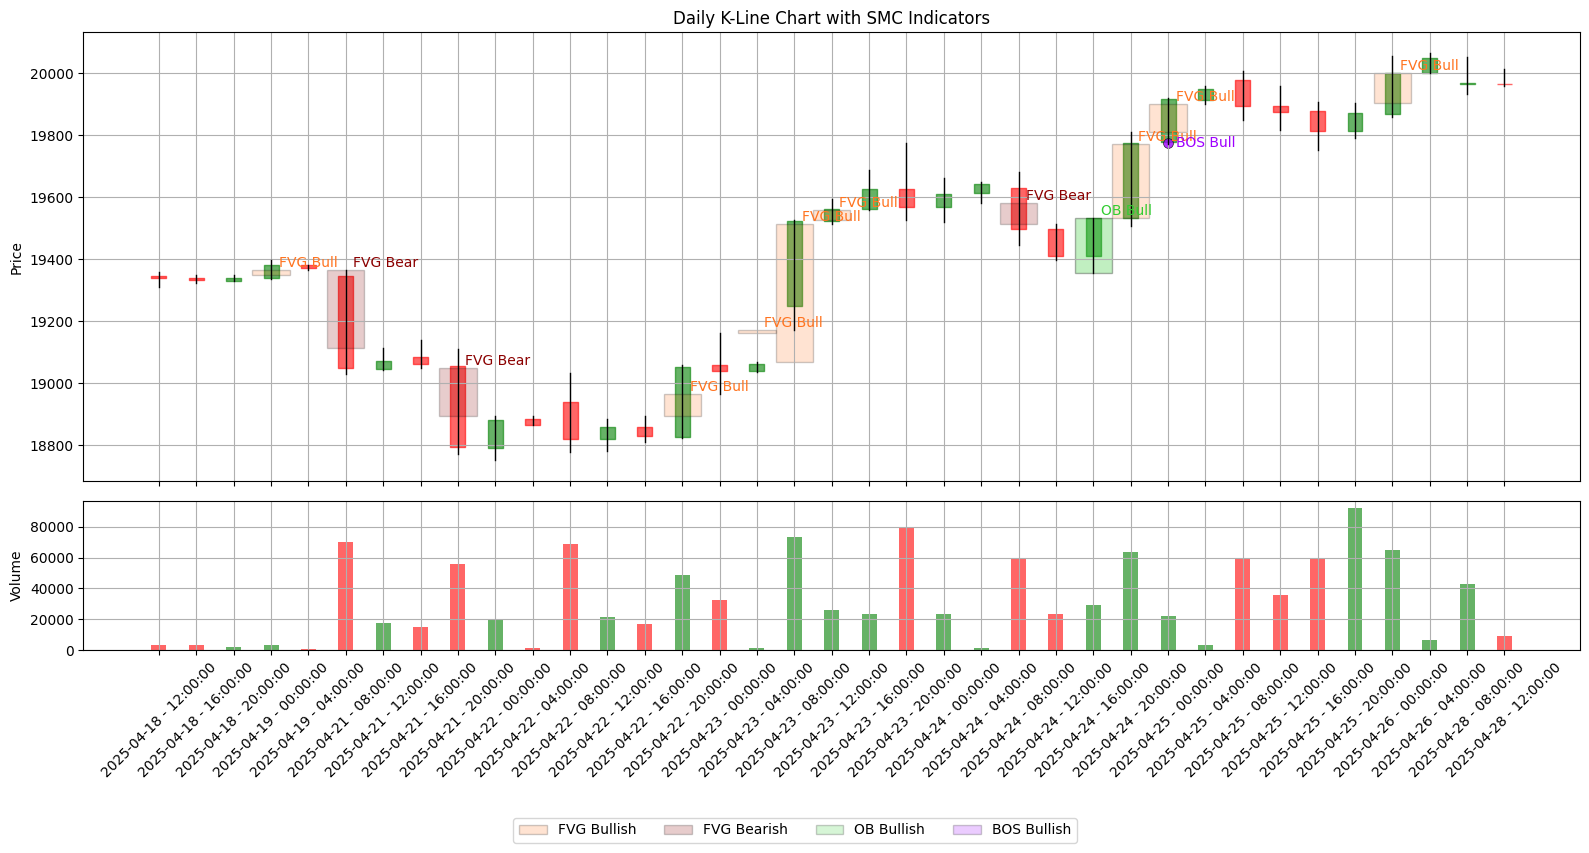

In [85]:
# 自定義顏色映射
custom_color_map = {
    'FVG':     {'bullish': '#FF7420', 'bearish': '#8B0000'},
    'OB':      {'bullish': '#32CD32', 'bearish': '#006400'},
    'Liquidity': {'bullish': '#1E90FF', 'bearish': '#000080'},
    'BOS':     {'bullish': '#9F00FF', 'bearish': '#2F4F4F'},
    'CHOCH':   {'bullish': '#FF69B4', 'bearish': '#4A0000'},
}

# 準備 SMC 指標字典
smc_indicators = {
    'FVG': fvg_data1,
    'OB': ob_data1,
    'Liquidity': liquidity_data1,
    'BOS': bos_data1,
    'CHOCH': choch_data1
}
 
# 繪製圖表
plot_smc_chart(
    data=data1,
    smc_indicators=smc_indicators,
    color_map=custom_color_map,
    title="Daily K-Line Chart with SMC Indicators",
    # save_path="chart.png"
)

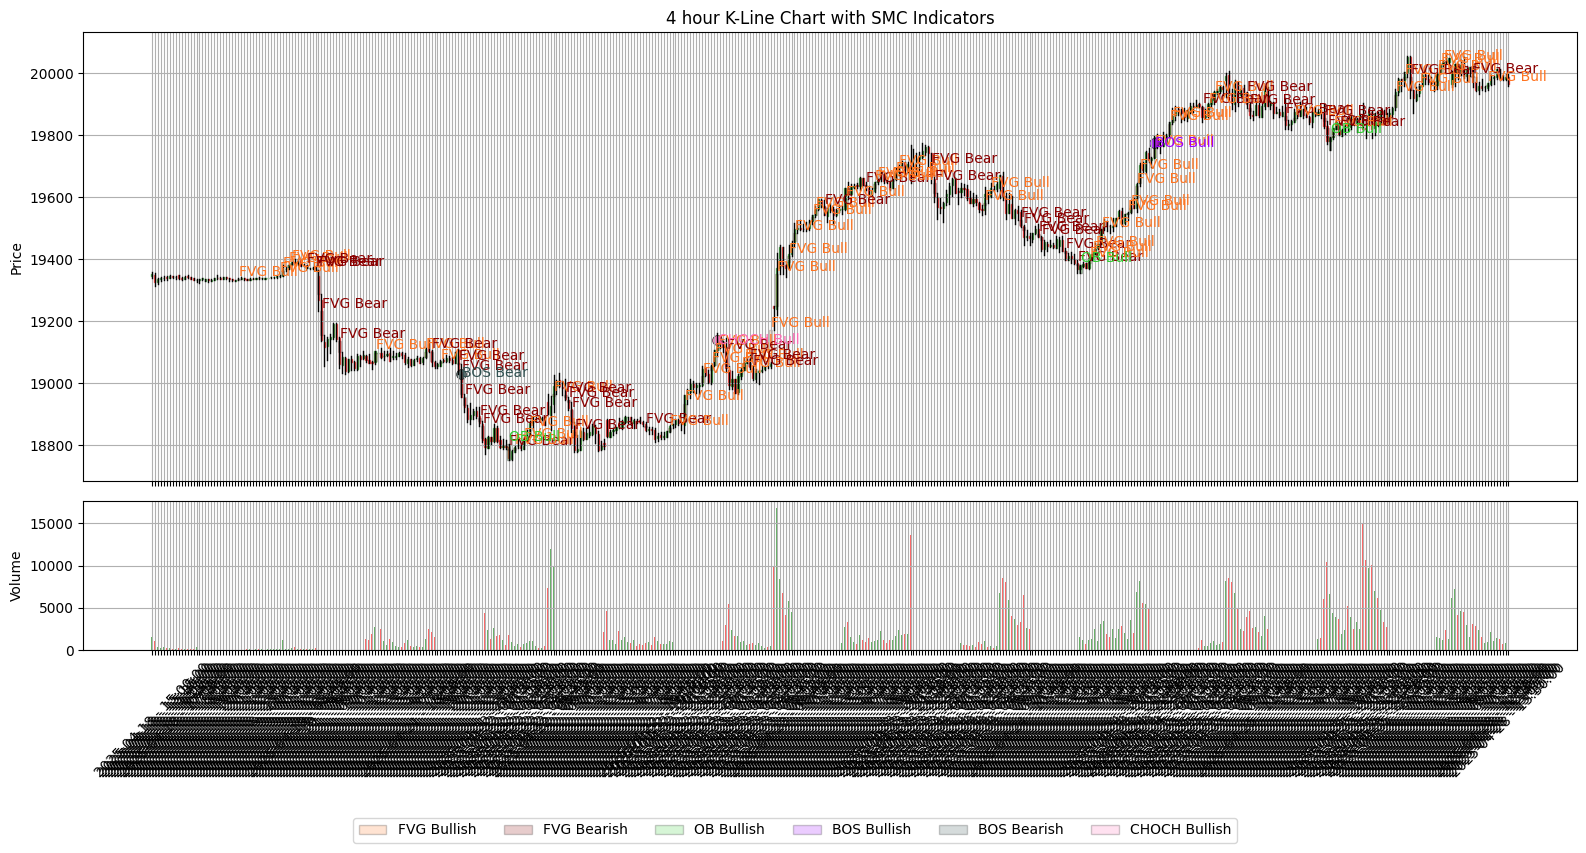

In [107]:
# 自定義顏色映射
custom_color_map = {
    'FVG':     {'bullish': '#FF7420', 'bearish': '#8B0000'},
    'OB':      {'bullish': '#32CD32', 'bearish': '#006400'},
    'Liquidity': {'bullish': '#1E90FF', 'bearish': '#000080'},
    'BOS':     {'bullish': '#9F00FF', 'bearish': '#2F4F4F'},
    'CHOCH':   {'bullish': '#FF69B4', 'bearish': '#4A0000'},
}

# 準備 SMC 指標字典
smc_indicators = {
    'FVG': fvg_data2,
    'OB': ob_data2,
    'Liquidity': liquidity_data2,
    'BOS': bos_data2,
    'CHOCH': choch_data2
}

# 繪製圖表
plot_smc_chart(
    data=data2,
    smc_indicators=smc_indicators,
    color_map=custom_color_map,
    title="4 hour K-Line Chart with SMC Indicators",
    # save_path="chart.png"
)